In [1]:
import requests
import pandas as pd
from urllib.request import Request, urlopen
from sodapy import Socrata
import json
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import ipywidgets as wd
from ipywidgets import interact
import seaborn as sns
import ptitprince as pt

# Variables de entorno:
En esta sección he creado las variables de entorno asociadas al token de la app generado por la API, el usuario y el password de usuario.

La API corresponde a los datos públicos del gobierno nacional, en este caso de la TRM, la cual se encuentra disponible en:
https://www.datos.gov.co/Econom-a-y-Finanzas/Tasa-de-Cambio-Representativa-del-Mercado-Historic/mcec-87by

In [2]:
with open("secret.json", "r") as f:
    config = json.load(f)

token = config["TOKEN_API_OD"]
user=config["user"]
passwd=config["pw"]

# Conexión con la API
Usando la librería sodapy se llama al cliente de Socrata recurriendo a las variables de entorno

In [3]:
client = Socrata('www.datos.gov.co',token,username=user,password=passwd)

In [4]:
results = client.get("mcec-87by", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# Dataframe de la TRM historica diaria 
Los campo vigenciadesde y vigenciahasta almacenan la fecha desde la que se mantuvo el valor de TRM hasta la fecha en la que caduco dicho valor de TRM

In [5]:
results_df

,valor,unidad,vigenciadesde,vigenciahasta
0,4231.97,COP,2023-10-11T00:00:00.000,2023-10-11T00:00:00.000
1,4386.66,COP,2023-10-07T00:00:00.000,2023-10-10T00:00:00.000
2,4359.4,COP,2023-10-06T00:00:00.000,2023-10-06T00:00:00.000
3,4252.09,COP,2023-10-05T00:00:00.000,2023-10-05T00:00:00.000
4,4187.01,COP,2023-10-04T00:00:00.000,2023-10-04T00:00:00.000
...,...,...,...,...
1995,2386.77,COP,2015-05-13T00:00:00.000,2015-05-13T00:00:00.000
1996,2381.53,COP,2015-05-12T00:00:00.000,2015-05-12T00:00:00.000
1997,2360.58,COP,2015-05-09T00:00:00.000,2015-05-11T00:00:00.000
1998,2369.23,COP,2015-05-08T00:00:00.000,2015-05-08T00:00:00.000


# Extracción desde el endpoint de la TRM

In [6]:
response = requests.get('https://www.datos.gov.co/resource/mcec-87by.json')
consulta=response.json()
pd.DataFrame.from_records(consulta)

,valor,unidad,vigenciadesde,vigenciahasta
0,4231.97,COP,2023-10-11T00:00:00.000,2023-10-11T00:00:00.000
1,4386.66,COP,2023-10-07T00:00:00.000,2023-10-10T00:00:00.000
2,4359.4,COP,2023-10-06T00:00:00.000,2023-10-06T00:00:00.000
3,4252.09,COP,2023-10-05T00:00:00.000,2023-10-05T00:00:00.000
4,4187.01,COP,2023-10-04T00:00:00.000,2023-10-04T00:00:00.000
...,...,...,...,...
995,3365.78,COP,2019-08-03T00:00:00.000,2019-08-05T00:00:00.000
996,3329.23,COP,2019-08-02T00:00:00.000,2019-08-02T00:00:00.000
997,3291.79,COP,2019-08-01T00:00:00.000,2019-08-01T00:00:00.000
998,3296.85,COP,2019-07-31T00:00:00.000,2019-07-31T00:00:00.000


# Funciones para extracción de detalles de fechas usando regex

Se construyen funciones haciendo uso de expresiones regulares para extraer la fecha en formato estándar y poder tratar los datos en series de tiempo de ser necesario(ver README_ENTREGA.txt

In [7]:
def extract_year(x):
    pattern = r"(\d{4})-\d{2}-\d{2}T"
    match = re.search(pattern, x)
    if match:
        return match.group(1)  # Retorna el año
    else:
        return None  # Retorna None si no hay coincidencia

In [8]:
def extract_month(x):
    pattern = r"(\d{4})-(\d{2})-\d{2}T"
    match = re.search(pattern, x)
    if match:
        return match.group(2)  # Retorna el año
    else:
        return None 

In [9]:
def extract_day(x):
    pattern = r"(\d{4})-(\d{2})-(\d{2})T"
    match = re.search(pattern, x)
    if match:
        return match.group(3)  # Retorna el año
    else:
        return None 

In [10]:
results_df['año'] = results_df['vigenciadesde'].apply(extract_year)
results_df['mes']=results_df['vigenciadesde'].apply(extract_month)
results_df['dia_inicial']=results_df['vigenciadesde'].apply(extract_day)
results_df['final']=results_df['vigenciahasta'].apply(extract_day)

In [11]:
results_df

,valor,unidad,vigenciadesde,vigenciahasta,año,mes,dia_inicial,final
0,4231.97,COP,2023-10-11T00:00:00.000,2023-10-11T00:00:00.000,2023,10,11,11
1,4386.66,COP,2023-10-07T00:00:00.000,2023-10-10T00:00:00.000,2023,10,07,10
2,4359.4,COP,2023-10-06T00:00:00.000,2023-10-06T00:00:00.000,2023,10,06,06
3,4252.09,COP,2023-10-05T00:00:00.000,2023-10-05T00:00:00.000,2023,10,05,05
4,4187.01,COP,2023-10-04T00:00:00.000,2023-10-04T00:00:00.000,2023,10,04,04
...,...,...,...,...,...,...,...,...
1995,2386.77,COP,2015-05-13T00:00:00.000,2015-05-13T00:00:00.000,2015,05,13,13
1996,2381.53,COP,2015-05-12T00:00:00.000,2015-05-12T00:00:00.000,2015,05,12,12
1997,2360.58,COP,2015-05-09T00:00:00.000,2015-05-11T00:00:00.000,2015,05,09,11
1998,2369.23,COP,2015-05-08T00:00:00.000,2015-05-08T00:00:00.000,2015,05,08,08


In [12]:
trm=results_df.copy()

In [13]:
trmFiltered=trm[['valor','mes','dia_inicial','final','año']]

In [14]:
trmFiltered

,valor,mes,dia_inicial,final,año
0,4231.97,10,11,11,2023
1,4386.66,10,07,10,2023
2,4359.4,10,06,06,2023
3,4252.09,10,05,05,2023
4,4187.01,10,04,04,2023
...,...,...,...,...,...
1995,2386.77,05,13,13,2015
1996,2381.53,05,12,12,2015
1997,2360.58,05,09,11,2015
1998,2369.23,05,08,08,2015


In [15]:
trmFiltered['fecha_inicial']=trmFiltered['año'].astype(str)+'-'+trmFiltered['mes'].astype(str).str.zfill(2)+'-'+trmFiltered['dia_inicial'].astype(str).str.zfill(2)
trmFiltered['fecha_final']=trmFiltered['año'].astype(str)+'-'+trmFiltered['mes'].astype(str).str.zfill(2)+'-'+trmFiltered['final'].astype(str).str.zfill(2)
trmFiltered['fecha_inicial']=pd.to_datetime(trmFiltered['fecha_inicial'])
trmFiltered['fecha_final']=pd.to_datetime(trmFiltered['fecha_final'])

# Dataframe filtrado con fechas iniciales y finales

In [16]:
trmFiltered

,valor,mes,dia_inicial,final,año,fecha_inicial,fecha_final
0,4231.97,10,11,11,2023,2023-10-11,2023-10-11
1,4386.66,10,07,10,2023,2023-10-07,2023-10-10
2,4359.4,10,06,06,2023,2023-10-06,2023-10-06
3,4252.09,10,05,05,2023,2023-10-05,2023-10-05
4,4187.01,10,04,04,2023,2023-10-04,2023-10-04
...,...,...,...,...,...,...,...
1995,2386.77,05,13,13,2015,2015-05-13,2015-05-13
1996,2381.53,05,12,12,2015,2015-05-12,2015-05-12
1997,2360.58,05,09,11,2015,2015-05-09,2015-05-11
1998,2369.23,05,08,08,2015,2015-05-08,2015-05-08


# Dataframe filtrado y restringido al gobierno actual (Gustavo Petro)

In [17]:
gobierno_petro=pd.Timestamp('2022-08-06')
trm_petro=trmFiltered.loc[trmFiltered['fecha_inicial']>=gobierno_petro]
trm_petro

,valor,mes,dia_inicial,final,año,fecha_inicial,fecha_final
0,4231.97,10,11,11,2023,2023-10-11,2023-10-11
1,4386.66,10,07,10,2023,2023-10-07,2023-10-10
2,4359.4,10,06,06,2023,2023-10-06,2023-10-06
3,4252.09,10,05,05,2023,2023-10-05,2023-10-05
4,4187.01,10,04,04,2023,2023-10-04,2023-10-04
...,...,...,...,...,...,...,...
273,4231.45,08,12,12,2022,2022-08-12,2022-08-12
274,4273.82,08,11,11,2022,2022-08-11,2022-08-11
275,4309.69,08,10,10,2022,2022-08-10,2022-08-10
276,4307.09,08,09,09,2022,2022-08-09,2022-08-09


In [18]:
trm_petro['año'] = trm_petro['año'].astype(int)
trm_petro['valor']=trm_petro['valor'].astype(float)

In [19]:
trm_petro['año'].dtype

dtype('int32')

In [20]:
trm_petro['valor'].dtype

dtype('float64')

# Raincloud plot para las distribuciones de los datos de la TRM durante el periodo del gobierno Petro 
Se observan distrubuciones bimodales para lo transcurrido del año 2022 y lo transcurrido del año 2023

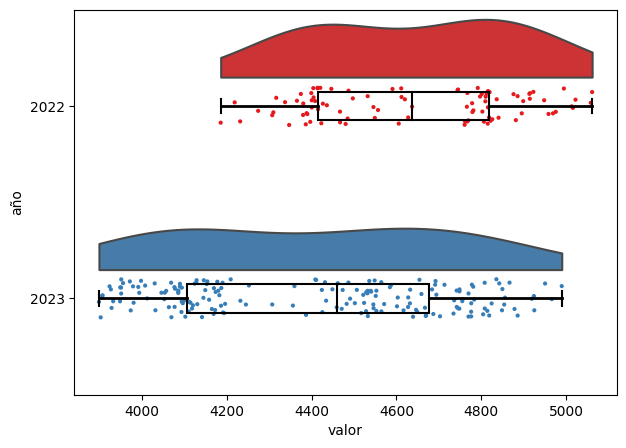

In [21]:
f, ax=plt.subplots(figsize=(7,5))
dy="año"; dx="valor"; ort="h";pal="Set1"

ax=pt.half_violinplot(x=dx,y=dy,data=trm_petro,palette=pal,bw=.6,cut=0.,scale="area",width= .6,inner=None,orient=ort)

ax=sns.stripplot( x = dx, y = dy, data =trm_petro, palette = pal,
 edgecolor = "white", size = 3, jitter = 1, zorder = 0,
 orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = trm_petro, color = "black", 
 width = .15, zorder = 10, showcaps = True,
 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
 whiskerprops = {'linewidth':2, "zorder":10},
 saturation = 1, orient = ort)

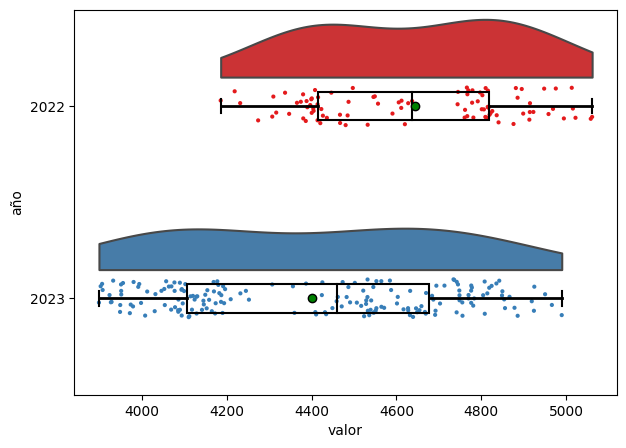

In [22]:
f, ax = plt.subplots(figsize=(7, 5))

dy = "año"
dx = "valor"
ort = "h"
pal = "Set1"

# Dibujo del violinplot, stripplot y boxplot
pt.half_violinplot(x=dx, y=dy, data=trm_petro, palette=pal, bw=.6, cut=0., scale="area", width=.6, inner=None, orient=ort, ax=ax)
sns.stripplot(x=dx, y=dy, data=trm_petro, palette=pal, edgecolor="white", size=3, jitter=1, zorder=0, orient=ort, ax=ax)
sns.boxplot(x=dx, y=dy, data=trm_petro, color="black", width=.15, zorder=10, showcaps=True, boxprops={'facecolor': 'none', "zorder": 10}, 
            showfliers=True, whiskerprops={'linewidth': 2, "zorder": 10}, saturation=1, orient=ort, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"green", "markeredgecolor":"black"}, ax=ax)

# Mostrar la trama
plt.savefig("trm.png")
plt.show()


In [23]:
trm_petro['valor'].describe()

count     278.000000
mean     4483.837086
std       312.005216
min      3898.480000
25%      4183.120000
50%      4522.640000
75%      4767.097500
max      5061.210000
Name: valor, dtype: float64

# Función para el cálculo del precio por unidad de una prenda (ropa deportiva) teniendo en cuenta la variación porcentual de la TRM durante lo transcurrido del Gobierno Petro

In [24]:
def uprice(uc,lc):
    up=(uc+lc)*(1+(2*trm_petro['valor'].std()/trm_petro['valor'].mean()))
    return up

In [25]:
uprice(22000,23000)

51262.59806384014